# Control hardware: pulse calibration
**Calibrating pulses for maximum performance on your hardware**

To make sure that the pulses you apply on your qubits perform the desired operations, you need first to calibrate them. This is true for any pulse, from a simple square waveform to more complex time-dependent controls, as the calibration corrects for discrepancies between the pulse that you programmed in your waveform generator and what actually reaches the qubit.

In this Application note, you'll find all the steps needed to calibrate your pulses, illustrated with examples on how to implement these techniques using IBM-Q hardware. In the first part, you'll learn how to map the output pulse amplitudes from BOULDER OPAL into hardware inputs. In the second part, you'll be presented with a fine-tuning calibration procedure for the $I$ and $Q$ values of a given pulse to maximize the gate fidelity.       

*Some cells in this notebook require an account with IBM-Q to execute correctly. If you want to run them, please go to the [IBM-Q experience](https://quantum-computing.ibm.com/login) to set up an account.*

## Imports and initialization

In [1]:
import jsonpickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls
from scipy import interpolate
from scipy.optimize import curve_fit

# Q-CTRL imports
from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

# Choose to run experiments or to use saved data
use_saved_data = True

# Plotting parameters
plt.style.use(get_qctrl_style())
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
markers = {"x": "x", "y": "s", "z": "o"}
lines = {"x": "--", "y": "-.", "z": "-"}

# Definition of operators and functions
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=np.complex)
X90_gate = np.array([[1.0, -1j], [-1j, 1.0]], dtype=np.complex) / np.sqrt(2)
bloch_basis = ["x", "y", "z"]


def save_var(file_name, var):
    # saves a single var to a file using jsonpickle
    f = open(file_name, "w+")
    to_write = jsonpickle.encode(var)
    f.write(to_write)
    f.close()


def load_var(file_name):
    # retuns a var from a json file
    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded


def fit_function_bounds(x_values, y_values, function, bound_values):
    fitparams, conv = curve_fit(function, x_values, y_values, bounds=bound_values)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit


def movingaverage(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


def simulation_coherent(control, time_samples):

    durations = [segment["duration"] for segment in control["I"]]
    I_values = np.array([segment["value"] for segment in control["I"]])
    Q_values = np.array([segment["value"] for segment in control["Q"]])
    duration = sum(durations)

    # Define shift controls
    shift_I = qctrl.types.coherent_simulation.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=d, value=v)
            for d, v in zip(durations, I_values)
        ],
        operator=sigma_x,
    )
    shift_Q = qctrl.types.coherent_simulation.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=d, value=v)
            for d, v in zip(durations, Q_values)
        ],
        operator=sigma_y,
    )

    # Define sample times for the output
    sample_times = np.linspace(0, duration, time_samples)

    # Define the target (optional)
    target = qctrl.types.TargetInput(operator=X90_gate)

    # Perform simulation
    simulation_result = qctrl.functions.calculate_coherent_simulation(
        duration=duration,
        sample_times=sample_times,
        shifts=[shift_I, shift_Q],
        initial_state_vector=np.array([1.0, 0.0]),
        target=target,
    )

    # Extract results
    gate_times = np.array([sample.time for sample in simulation_result.samples])
    state_vectors = np.array(
        [sample.state_vector for sample in simulation_result.samples]
    )
    infidelities = np.array([sample.infidelity for sample in simulation_result.samples])

    bloch_vector_components = {
        "x": np.real(
            np.array(
                [
                    np.linalg.multi_dot([np.conj(state), sigma_x, state])
                    for state in state_vectors
                ]
            )
        ),
        "y": np.real(
            np.array(
                [
                    np.linalg.multi_dot([np.conj(state), sigma_y, state])
                    for state in state_vectors
                ]
            )
        ),
        "z": np.real(
            np.array(
                [
                    np.linalg.multi_dot([np.conj(state), sigma_z, state])
                    for state in state_vectors
                ]
            )
        ),
    }

    return infidelities, bloch_vector_components, gate_times


import warnings

warnings.simplefilter("ignore")
use_IBM = False

if use_IBM == True:
    # IBM-Q imports
    import qiskit.pulse as pulse
    import qiskit.pulse.pulse_lib as pulse_lib
    from qiskit import IBMQ
    from qiskit.compiler import assemble
    from qiskit.pulse import Acquire, Play, Schedule
    from qiskit.tools.jupyter import *
    from qiskit.tools.monitor import job_monitor

    # IBM credentials and backend selection
    IBMQ.enable_account("your IBM token")
    provider = IBMQ.get_provider(
        hub="your hub", group="your group", project="your project"
    )
    backend = provider.get_backend("ibmq_valencia")
    backend_defaults = backend.defaults()
    backend_config = backend.configuration()

    # Backend properties
    dt = backend_config.dt
    print(f"Hardware sampling time: {dt/1e-9} ns")

    qubit_freq_est = []
    for qubit in backend_config.meas_map[0]:
        qubit_freq_est.append(backend_defaults.qubit_freq_est[qubit])
        print(f"Qubit [{qubit}] frequency estimate: {qubit_freq_est[qubit]/1e9} GHz")

## Basic Rabi rate calibration

The result returned from a BOULDER OPAL optimization is a piecewise constant pulse given in terms of a complex-valued waveform 

\begin{align*}
    \gamma(t) & = I(t) + i Q(t)\\
            &= \Omega(t) e^{i\phi(t)}
\end{align*}

as a function of time $t$. The IQ variables relate to the (on-resonance) Rabi rate $\Omega$ and drive phase $\phi$ as 

\begin{align*}
I = \Omega \cos(\phi),\\
Q = \Omega \sin(\phi),\\
|\gamma|\le\Omega_\text{max}.
\end{align*}

If you're implementing the control pulse in your own experiment or in a quantum computing platform in the cloud, you need to know how the ($I$, $Q$) pulse values are connected to the input pulse parameters in your system. On the IBM hardware, pulses are defined in terms of dimensionless variables $A = A_I + i A_Q$, with real and imaginary components proportional to physical input voltages, and bounded as

\begin{align*}
A_I \in [-1,1] \\
A_Q \in [-1,1] \\
|A|\le 1.
\end{align*}

The goal of this calibration routine is establish the map
 
\begin{align*}
(A_I, A_Q) \longleftrightarrow (I, Q)
\end{align*}

from hardware amplitudes to control pulse amplitudes.  

### Calibration procedure

The calibration steps to obtain the map above are:

1. Pick a given hardware input amplitude $A_I$ and create a constant rectangular pulse to act on the system.

2. With the pulse from (1), perform a Rabi experiment by varying the pulse duration and measuring the qubit population. This will show Rabi oscillations over time, which you can use to fit a cosine function and find the corresponding Rabi rate. Varying the pulse duration has the benefit of avoiding possible nonlinearities that can distort fitting of Rabi oscillations, encountered when scanning the amplitudes to observe Rabi oscillations.

3. Repeat steps (1) and (2) with different values of the amplitude $A_I$ and make a table with the correspondence between $A_I$ and $I$. This correspondence will not necessarily be linear. Using this data set, create a interpolating function that connects the $I$ values to the $A_I$ amplitudes. Usually there is no need to repeat the calibration for $Q$ as the relationship obtained for $I$ also holds for $Q \leftrightarrow A_Q$.

4. The result from (3) can be used to translate the $(I, Q)$ values in an arbitrary Q-CTRL pulse into the appropriate $(A_I, A_Q)$ hardware input amplitudes.

The cell below sets up these steps and runs them on the IBMQ Valencia backend. 


Drive amplitude: 0.2
Fitted Rabi frequency [Hz]: 16000000.000000285


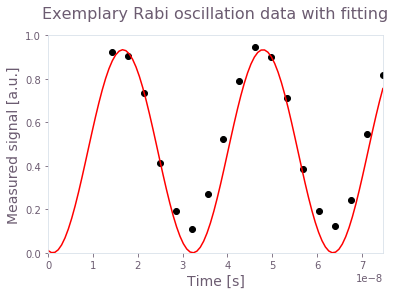

In [15]:
# Setting up calibration experiments
qubit = 0
dt = 2 / 9 * 1e-9
num_shots_per_point = 1024
pulse_amp_array = np.linspace(0.05, 0.2, 7)
pulse_times = np.array(
    [4 + np.arange(0, int(3.6 / (amplitude)), 1) for amplitude in pulse_amp_array]
)
pulse_times = pulse_times * 16

if use_saved_data == False:
    backend.properties(refresh=True)
    qubit_frequency_updated = backend.properties().qubit_property(qubit, "frequency")[0]

    meas_map_idx = None
    for i, measure_group in enumerate(backend_config.meas_map):
        if qubit in measure_group:
            meas_map_idx = i
            break
    assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

    inst_sched_map = backend_defaults.instruction_schedule_map
    measure_schedule = inst_sched_map.get("measure", qubits=[qubit])
    drive_chan = pulse.DriveChannel(qubit)

    rabi_programs_dic_I = {}
    for idx, pulse_amplitude in enumerate(pulse_amp_array):
        rabi_schedules_I = []
        for duration_pulse in pulse_times[idx]:
            drive_pulse = pulse_lib.gaussian_square(
                duration=duration_pulse,
                sigma=1,
                amp=pulse_amplitude,
                risefall=1,
                name=f"square_pulse_{duration_pulse}",
            )
            schedule = pulse.Schedule(name=str(duration_pulse))
            schedule |= (
                Play(drive_pulse, pulse.DriveChannel(qubit)) << schedule.duration
            )
            schedule += measure_schedule << schedule.duration
            rabi_schedules_I.append(schedule)
        rabi_experiment_program_I = assemble(
            rabi_schedules_I,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * len(pulse_times[idx]),
        )
        rabi_programs_dic_I[pulse_amplitude] = rabi_experiment_program_I

    # Running calibration experiments
    rabi_calibration_exp_I = []
    rabi_oscillations_results = []
    for idx, pulse_amplitude in enumerate(pulse_amp_array):
        job = backend.run(rabi_programs_dic_I[pulse_amplitude])
        job_monitor(job)
        rabi_results = job.result(timeout=120)
        rabi_values = []
        time_array = pulse_times[idx] * dt
        for time_idx in pulse_times[idx]:
            counts = rabi_results.get_counts(str(time_idx))
            excited_pop = 0
            for bits, count in counts.items():
                excited_pop += count if bits[::-1][qubit] == "1" else 0
            rabi_values.append(excited_pop / num_shots_per_point)

        rabi_oscillations_results.append(rabi_values)
        fit_parameters, y_fit = fit_function_bounds(
            time_array,
            rabi_values,
            lambda x, A, rabi_freq, phi: A
            * np.cos(2 * np.pi * rabi_freq * x + phi) ** 2,
            (
                [0.8, np.abs(pulse_amplitude * 8 * 1e7), -4],
                [1, np.abs(pulse_amplitude * 11 * 1e7), 4],
            ),
        )

        rabi_calibration_exp_I.append(fit_params[1])

    save_var(
        "resources/superconducting-qubits-pulse-calibration/rabi_calibration_Valencia_qubit_0",
        rabi_calibration_exp_I,
    )
    save_var(
        "resources/superconducting-qubits-pulse-calibration/fit_parameters",
        fit_parameters,
    )
    save_var(
        "resources/superconducting-qubits-pulse-calibration/rabi_values", rabi_values
    )
else:
    rabi_calibration_exp_I = load_var(
        "resources/superconducting-qubits-pulse-calibration/rabi_calibration_Valencia_qubit_0"
    )
    fit_parameters = load_var(
        "resources/superconducting-qubits-pulse-calibration/fit_parameters"
    )
    rabi_values = load_var(
        "resources/superconducting-qubits-pulse-calibration/rabi_values"
    )

time_array = pulse_times[-1] * dt
print("Drive amplitude:", pulse_amp_array[-1])
print("Fitted Rabi frequency [Hz]:", fit_parameters[1])
plt.title("Exemplary Rabi oscillation data with fitting", fontsize=16, y=1.05)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Measured signal [a.u.]", fontsize=14)
plt.scatter(time_array, np.real(rabi_values), color="black")
plt.xlim(0, time_array[-1])
plt.ylim(0, 1)
plot_times = np.linspace(0, time_array[-1], 100)
plt.plot(
    plot_times,
    fit_parameters[0]
    * np.cos(2 * np.pi * fit_parameters[1] * plot_times + fit_parameters[2]) ** 2,
    color="red",
)
plt.show()

The figure shows the result of a Rabi experiment for an amplitude $A_I = 0.2$ (circles) and the correponding cosine square fit (line). 

You can now collect all the $I$ values from the previous experiment and establish the correspondence between $I$ and $A_I$. This is done in the cell below. 

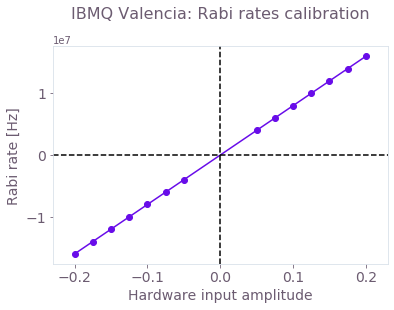

In [16]:
amplitude_interpolated_list = np.linspace(-0.2, 0.2, 100)
pulse_amp_array = np.concatenate((-pulse_amp_array[::-1], pulse_amp_array))
rabi_calibration_exp_I = np.concatenate(
    (-np.asarray(rabi_calibration_exp_I[::-1]), np.asarray(rabi_calibration_exp_I))
)
f_amp_to_rabi = interpolate.interp1d(pulse_amp_array, rabi_calibration_exp_I)
rabi_interpolated_exp_I = f_amp_to_rabi(amplitude_interpolated_list)

f_rabi_to_amp = interpolate.interp1d(
    rabi_interpolated_exp_I, amplitude_interpolated_list
)

plt.title("IBMQ Valencia: Rabi rates calibration", fontsize=16, y=1.1)
plt.xlabel("Hardware input amplitude", fontsize=14)
plt.ylabel("Rabi rate [Hz]", fontsize=14)
plt.scatter(pulse_amp_array, rabi_calibration_exp_I)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.plot(amplitude_interpolated_list, rabi_interpolated_exp_I)
plt.axvline(0, color="black", linestyle="dashed")
plt.axhline(0, color="black", linestyle="dashed")
plt.show()

Mapping between the Rabi rates and the dimensionless hardware input. The calibration was done in the interval $[-0.2, 0.2]$, where the relationship is linear. 

### Verifying basic calibration

Now that you have performed the basic calibration, you may want to test it on your device. In the Application Note ["Superconducting qubits: improving the performance of single qubit gates"](https://docs.q-ctrl.com/boulder-opal/application-notes/superconducting-qubits-improving-the-performance-of-single-qubit-gates) you'll find a detailed explanation on how to construct robust pulses for superconducting qubit systems. Here, however, you don't need to create your own pulse as a previously generated control is provided to verify the calibration procedure. When executing the next cell, you'll import this control pulse, extract some of its properties for later use, and plot its values.

Amplitude robust


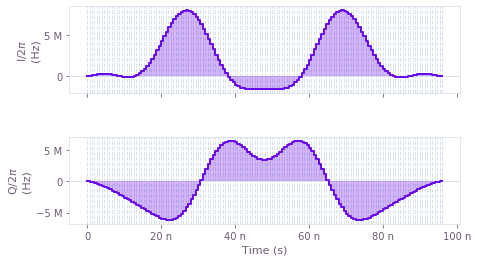

In [17]:
# Import pulses
gate_schemes = load_var(
    "resources/superconducting-qubits-pulse-calibration/pulse_amplitude_robust"
)

# Extract pulse properties
number_of_segments = {}
duration_int = {}
duration = {}
segment_scale = {}
waveform = {}
for scheme_name, control in gate_schemes.items():
    number_of_segments[scheme_name] = len(control["I"])
    duration[scheme_name] = sum(values["duration"] for values in control["I"])
    duration_int[scheme_name] = int(round(duration[scheme_name] / dt))
    segment_scale[scheme_name] = (
        duration_int[scheme_name] / number_of_segments[scheme_name]
    )
    I_values = [segment["value"] / 2 / np.pi for segment in control["I"]]
    Q_values = [segment["value"] / 2 / np.pi for segment in control["Q"]]
    A_I_values = np.repeat(f_rabi_to_amp(I_values), segment_scale[scheme_name])
    A_Q_values = np.repeat(f_rabi_to_amp(Q_values), segment_scale[scheme_name])
    waveform[scheme_name] = A_I_values + 1j * A_Q_values

# Plot pulses
for scheme_name, gate in gate_schemes.items():
    print(scheme_name)
    plot_controls(plt.figure(), gate)
    plt.show()

I and Q components of the microwave drive on the qubit for an amplitude robust pulse that performs a $\pi/2$ rotation around the $x$ axis (an $X_{\pi/2}$ gate). Note that the values of the pulse waveform are given in Hz.

To verify the calibration, you can run this pulse on the device and check that it executes the desired gate. This is done in the next cell, where the outputs are the $(x, y, z)$ components of the Bloch vector for the qubit.

In [18]:
# Creating IBM schedules
ibm_evolution_times = {}
times_int = {}
pulse_evolution_program = {}
time_min = 64
time_step = 16
for scheme_name in gate_schemes.keys():
    time_max = int(segment_scale[scheme_name] * number_of_segments[scheme_name])
    times_int[scheme_name] = np.arange(time_min, time_max + time_step, time_step)
    ibm_evolution_times[scheme_name] = times_int[scheme_name] * dt

if use_saved_data == False:
    for scheme_name in gate_schemes.keys():
        evolution_schedules = []
        for meas_basis in bloch_basis:
            for time_idx in times_int[scheme_name]:
                schedule = pulse.Schedule(
                    name="Basis_%s_duration_%d" % (meas_basis, time_idx)
                )
                schedule += Play(Waveform(waveform[scheme_name][:time_idx]), drive_chan)
                if meas_basis == "x":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "y":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "z":
                    schedule += measure_schedule << schedule.duration
                evolution_schedules.append(schedule)

        pulse_evolution_program[scheme_name] = assemble(
            evolution_schedules,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * len(times_int[scheme_name])
            * 3,
        )

    # Running the jobs
    evolution_exp_results = {}
    for scheme_name in gate_schemes.keys():
        job = backend.run(pulse_evolution_program[scheme_name])
        job_monitor(job)
        evolution_exp_results[scheme_name] = job.result(timeout=120)

    # Extract results
    evolution_results_ibm = {}
    for scheme_name in gate_schemes.keys():
        evolution_basis = {}
        for meas_basis in bloch_basis:
            evolution_exp_data = np.zeros(len(times_int[scheme_name]))
            for idx, time_idx in enumerate(times_int[scheme_name]):
                counts = evolution_exp_results[scheme_name].get_counts(
                    "Basis_%s_duration_%d" % (meas_basis, time_idx)
                )
                excited_pop = 0
                for bits, count in counts.items():
                    excited_pop += count if bits[::-1][qubit] == "1" else 0
                evolution_exp_data[idx] = excited_pop / num_shots_per_point
            evolution_basis[meas_basis] = evolution_exp_data
        evolution_results_ibm[scheme_name] = evolution_basis

    save_var(
        "resources/superconducting-qubits-pulse-calibration/evolution_exp_results_Valencia_qubit_0",
        evolution_results_ibm,
    )
else:
    evolution_results_ibm = load_var(
        "resources/superconducting-qubits-pulse-calibration/evolution_exp_results_Valencia_qubit_0"
    )

You can now use the BOULDER OPAL simulation feature to obtain the expected evolution of the qubit under the selected pulse and compare it with the experimental results.  

Amplitude robust


100%|██████████| 100/100 [00:02<00:00, 33.43it/s]


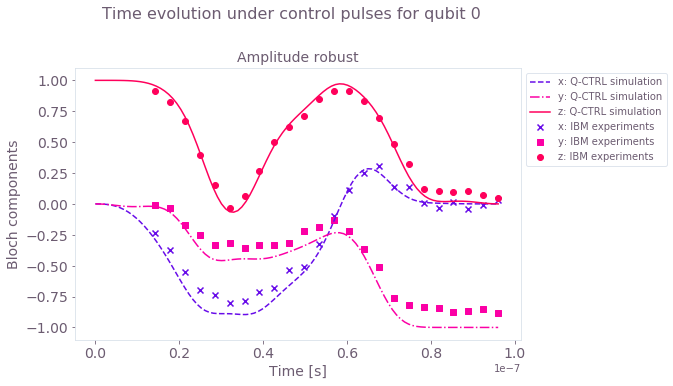

In [19]:
# Q-CTRL simulations
simulated_bloch = {}
gate_times = {}
infidelities = {}
for scheme_name, control in gate_schemes.items():
    print(scheme_name)
    (
        infidelities[scheme_name],
        simulated_bloch[scheme_name],
        gate_times[scheme_name],
    ) = simulation_coherent(control, 100)

# Plotting
gs = gridspec.GridSpec(1, len(gate_schemes.keys()), hspace=0.5)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)
fig.suptitle(
    "Time evolution under control pulses for qubit " + str(qubit), fontsize=16, y=1.05
)

for idx, scheme_name in enumerate(gate_schemes.keys()):
    ax = fig.add_subplot(gs[idx])
    for meas_basis in bloch_basis:
        ax.plot(
            gate_times[scheme_name],
            simulated_bloch[scheme_name][meas_basis],
            ls=lines[meas_basis],
            label="%s: Q-CTRL simulation" % (meas_basis),
        )
        ax.scatter(
            ibm_evolution_times[scheme_name],
            1 - 2 * evolution_results_ibm[scheme_name][meas_basis],
            label="%s: IBM experiments" % (meas_basis),
            marker=markers[meas_basis],
        )
    ax.set_title(scheme_name, fontsize=14)
    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Bloch components", fontsize=14)
    ax.tick_params(labelsize=14)
ax.legend(loc="best", bbox_to_anchor=(1, 1))

plt.show()

Time evolution of the Bloch vector components for the amplitude-robust $X_{\pi/2}$ gate. The experimental results (symbols) follow the numerical simulation (lines) with deviations mostly due to readout errors.

## Fine-tuning of individual pulses

The basic calibration that you've just performed is general in the sense that it is independent of the pulse applied. However, it is not the most accurate calibration method. Note that, in a real device, the pulse that is programmed in your wave generator is most likely not what reaches the physical qubit due to hardware bandwidth limitations and imperfections in the control lines.  

An improved calibration procedure starts from the basic calibration discussed before and introduces two scaling factors $S_{rel}$ and $S_{amp}$ so that

\begin{align*}
    \gamma(t) = S_{amp} (S_{rel} I(t) + i Q(t)).
\end{align*}

The $S_{rel}$ factor allows you to account for relative differences between the designed and the actual values of $I$ and $Q$ reaching the qubit, while $S_{amp}$ accounts for an absolute amplitude scaling. Note that it is enough to scan these scaling factors around $1$ since $S_{amp} = S_{rel} = 1$ corresponds to the values obtained from the previous basic calibration. 

For a procedure that is maximally sensitive to coherent errors due to miscalibration, you should apply your pulse multiple times to allow for these errors to pile up. For the $X_{\pi/2}$ pulses, you can use $N = (1 + 4n)$ repetitions with $n \in \{0, 1 \cdots \}$ so that the Bloch vector always ends up in the same point if the pulse is perfect. The calibration steps are:

1. Using two sequences with different numbers of pulse repetitions ($N_1$ and $N_2$), perform experiments where you scan over the values of $S_{rel}$ around $1$ (no scaling), and calculate the gate infidelity as a function of this scaling factor.

2. Find the value of the scaling factor, $S_{rel}$, that minimizes the infidelity for *both* repetition numbers. You could be tempted to use a single repetition number $N$ to speed up your calibration but this is not advisable. Note that, if you pick $N$ that is too small, there will be little variation of the infidelity with $S_{rel}$ and your calibration would be innacurate. If you select $N$ that is too large, you may see multiple infidelity minima as small changes in $S_{rel}$ can lead to full rotations in the Bloch sphere. In this case, you may be selecting the wrong scaling factor. Using two values allows you to find a single scaling that best calibrates your pulse.

3. Repeat step 2. but now scaning $S_{amp}$ and using the value of $S_{rel}$ found in the previous step. Again, find the scaling factor that minimizes the infidelith for both pulse repetition numbers. 

### Relative scaling calibration

The next cell runs the scan over $S_{rel}$ described in step 1 for $N_1 = 49$ and $N_2 =101$ and then finds the best relative scaling described in step 2.

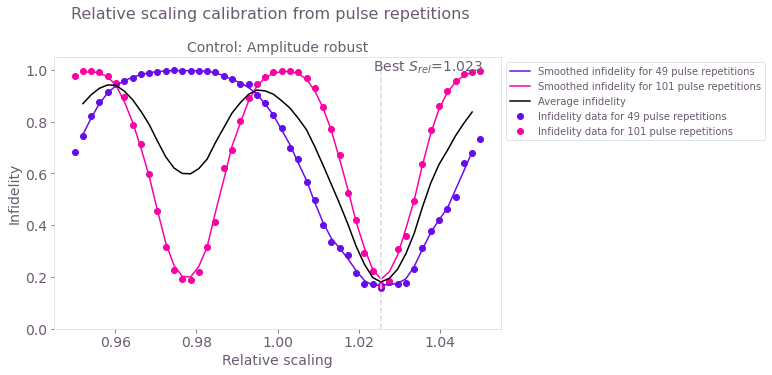

In [8]:
repetitions = np.array([49, 101])
scalings = np.linspace(0.95, 1.05, 50)

if use_saved_data == False:
    pulse_program = {}
    for scheme_name in gate_schemes.keys():
        schedules = []
        for meas_basis in bloch_basis:
            for repetition in repetitions:
                for scaling_factor_I in scalings:
                    Ival = np.real(waveform[scheme_name]) * scaling_factor_I
                    Qval = np.imag(waveform[scheme_name])
                    scaled_waveform = Ival + 1j * Qval
                    control_pulse = Play(Waveform(scaled_waveform), drive_chan)
                    schedule = pulse.Schedule(
                        name=f"pi_pulse_scal_{scaling_factor_I}_reps_"
                        + str(repetition)
                        + "_basis_"
                        + str(meas_basis)
                    )
                    for reps in np.arange(repetition):
                        schedule += control_pulse
                    if meas_basis == "x":
                        schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
                        schedule += measure_schedule << schedule.duration
                    if meas_basis == "y":
                        schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
                        schedule += measure_schedule << schedule.duration
                    if meas_basis == "z":
                        schedule |= measure_schedule << schedule.duration
                    schedules.append(schedule)
        pulse_program[scheme_name] = assemble(
            schedules,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * (repetitions.shape[0])
            * (scalings.shape[0])
            * 3,
        )

    # Running the jobs
    exp_results = {}
    for scheme_name in gate_schemes.keys():
        print("Control Scheme:", scheme_name)
        job = backend.run(pulse_program[scheme_name])
        print("Job id:", job.job_id())
        job_monitor(job)
        exp_results[scheme_name] = job.result(timeout=120)

    # Extract results
    I_calibration_data = {}
    for scheme_name, results in exp_results.items():
        print(scheme_name)
        idx = 0
        result_bloch = []
        for meas_basis in bloch_basis:
            full_res = []
            for idx_rep, number_of_repetitions in enumerate(repetitions):
                rep_res = []
                for scaling_factor in scalings:
                    counts = results.get_counts()[idx]
                    excited_pop = 0
                    idx += 1
                    for bits, count in counts.items():
                        excited_pop += count if bits[::-1][qubit] == "1" else 0
                    rep_res.append(excited_pop / num_shots_per_point)
                full_res.append(rep_res)
            result_bloch.append(1 - 2 * np.asarray(full_res))
        I_calibration_data[scheme_name] = np.asarray(result_bloch)

    save_var(
        "resources/superconducting-qubits-pulse-calibration/relative_calibration_data_Valencia_qubit_0",
        I_calibration_data,
    )

else:
    I_calibration_data = load_var(
        "resources/superconducting-qubits-pulse-calibration/relative_calibration_data_Valencia_qubit_0"
    )

# Infidelities for repetition experiments
target_bloch = np.array([0, -1, 0])
bloch_infidelity = {}
for scheme_name in gate_schemes.keys():
    bloch_vectors = np.array(
        [
            np.array(
                [
                    I_calibration_data[scheme_name][:, rep, idx]
                    for idx in range(scalings.shape[0])
                ]
            )
            for rep in range(repetitions.shape[0])
        ]
    )
    bloch_infidelity[scheme_name] = (
        1 - ((1 + np.dot(bloch_vectors, target_bloch)) / 2) ** 2
    )

# Plotting
gs = gridspec.GridSpec(1, len(gate_schemes.keys()), wspace=0.2, hspace=0.4)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)
fig.suptitle(
    f"Relative scaling calibration from pulse repetitions", fontsize=16, y=1.02
)

best_scaling_I = {}
average_infidelity = {}
for idx, scheme_name in enumerate(gate_schemes.keys()):
    ax = fig.add_subplot(gs[idx])
    infidelity_smoothed = []
    for idx, pulse_repetition in enumerate(repetitions):
        infidelity_smoothed.append(
            movingaverage(bloch_infidelity[scheme_name][idx, :], 3)
        )
        ax.set_title("Control: " + str(scheme_name), fontsize=14)
        ax.scatter(
            scalings,
            bloch_infidelity[scheme_name][idx, :],
            label="Infidelity data for %s pulse repetitions" % (pulse_repetition),
        )
        ax.plot(
            scalings[1:-1],
            infidelity_smoothed[-1],
            label="Smoothed infidelity for %s pulse repetitions" % (pulse_repetition),
        )
        ax.set_xlabel("Relative scaling", fontsize=14)
        ax.set_ylabel("Infidelity", fontsize=14)
        ax.tick_params(labelsize=14)
    average_infidelity[scheme_name] = np.average(infidelity_smoothed, axis=0)
    best_scaling_I[scheme_name] = scalings[
        np.argmin(average_infidelity[scheme_name]) + 1
    ]
    ax.plot(
        scalings[1:-1],
        average_infidelity[scheme_name],
        label="Average infidelity",
        c="k",
    )
    ax.axvline(best_scaling_I[scheme_name], ls="--")
    ax.text(
        scalings[np.argmin(infidelity_smoothed) + 1],
        np.max(infidelity_smoothed),
        "Best $S_{rel}$=" + str(round(scalings[np.argmin(infidelity_smoothed) + 1], 3)),
        fontsize=14,
    )
    ax.set_ylim(0, 1.05)
ax.legend(loc="best", bbox_to_anchor=(1, 1))
plt.show()

Infidelity as a function of $S_{rel}$ for 49 and 101 repetitions of the pulse. The solid lines are a moving average of the experimental results (symbols) using the values from 3 points. The black solid line is the average between the 49 and 101 repetitions experiments. The scaling factor that you should use when calibrating your pulse is the one that minimizes the average infidelity.

### Amplitude scaling calibration

The next cell repeats steps 1 and 2 but now for the scaling factor $S_{amp}$.

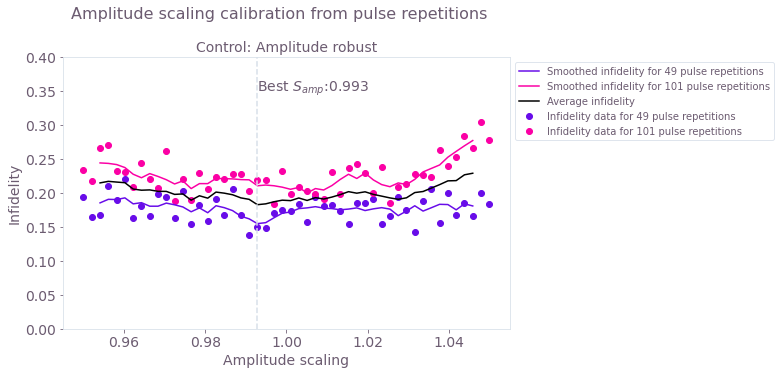

In [9]:
repetitions = np.array([49, 101])
scalings = np.linspace(0.95, 1.05, 50)

if use_saved_data == False:
    pulse_program = {}
    for scheme_name in gate_schemes.keys():
        schedules = []
        for meas_basis in bloch_basis:
            for repetition in repetitions:
                for scaling_factor in scalings:
                    scaled_waveform = (
                        np.real(waveform[scheme_name]) * best_scaling_I[scheme_name]
                        + 1j * np.imag(waveform[scheme_name])
                    ) * scaling_factor
                    control_pulse = Play(Waveform(scaled_waveform), drive_chan)
                    schedule = pulse.Schedule(
                        name=f"pi_pulse_scal_{scaling_factor}_reps_"
                        + str(repetition)
                        + "_basis_"
                        + str(meas_basis)
                    )
                    for reps in np.arange(repetition):
                        schedule += control_pulse
                    if meas_basis == "x":
                        schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
                        schedule += measure_schedule << schedule.duration
                    if meas_basis == "y":
                        schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
                        schedule += measure_schedule << schedule.duration
                    if meas_basis == "z":
                        schedule |= measure_schedule << schedule.duration
                    schedules.append(schedule)
        pulse_program[scheme_name] = assemble(
            schedules,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * (repetitions.shape[0])
            * (scalings.shape[0])
            * 3,
        )

    # Running the jobs
    exp_results = {}
    for scheme_name in gate_schemes.keys():
        print("Control Scheme:", scheme_name)
        job = backend.run(pulse_program[scheme_name])
        print("Job id:", job.job_id())
        job_monitor(job)
        exp_results[scheme_name] = job.result(timeout=120)

    # Extract results
    amplitude_calibration_data = {}
    for scheme_name, results in exp_results.items():
        print(scheme_name)
        idx = 0
        result_bloch = []
        for meas_basis in bloch_basis:
            full_res = []
            for idx_rep, number_of_repetitions in enumerate(repetitions):
                rep_res = []
                for scaling_factor in scalings:
                    counts = results.get_counts()[idx]
                    excited_pop = 0
                    idx += 1
                    for bits, count in counts.items():
                        excited_pop += count if bits[::-1][qubit] == "1" else 0
                    rep_res.append(excited_pop / num_shots_per_point)
                full_res.append(rep_res)
            result_bloch.append(1 - 2 * np.asarray(full_res))
        amplitude_calibration_data[scheme_name] = np.asarray(result_bloch)

    save_var(
        "resources/superconducting-qubits-pulse-calibration/amplitude_calibration_data_Valencia_qubit_0",
        amplitude_calibration_data,
    )
else:
    amplitude_calibration_data = load_var(
        "resources/superconducting-qubits-pulse-calibration/amplitude_calibration_data_Valencia_qubit_0"
    )

# Infidelities for repetition experiments
bloch_infidelity = {}
for scheme_name in gate_schemes.keys():
    bloch_vectors = np.array(
        [
            np.array(
                [
                    amplitude_calibration_data[scheme_name][:, rep, idx]
                    for idx in range(scalings.shape[0])
                ]
            )
            for rep in range(repetitions.shape[0])
        ]
    )
    bloch_infidelity[scheme_name] = (
        1 - ((1 + np.dot(bloch_vectors, target_bloch)) / 2) ** 2
    )

gs = gridspec.GridSpec(1, len(gate_schemes.keys()))
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)
fig.suptitle(
    f"Amplitude scaling calibration from pulse repetitions", fontsize=16, y=1.02
)

best_scaling_amplitude = {}
average_infidelity = {}
for idx, scheme_name in enumerate(gate_schemes.keys()):
    ax = fig.add_subplot(gs[idx])
    infidelity_smoothed = []
    for idx, pulse_repetition in enumerate(repetitions):
        infidelity_smoothed.append(
            movingaverage(bloch_infidelity[scheme_name][idx, :], 5)
        )
        ax.set_title("Control: " + str(scheme_name), fontsize=14)
        ax.scatter(
            scalings,
            bloch_infidelity[scheme_name][idx, :],
            label="Infidelity data for %s pulse repetitions" % (pulse_repetition),
        )
        ax.plot(
            scalings[2:-2],
            infidelity_smoothed[-1],
            label="Smoothed infidelity for %s pulse repetitions" % (pulse_repetition),
        )
        ax.set_xlabel("Amplitude scaling", fontsize=14)
        ax.set_ylabel("Infidelity", fontsize=14)
        ax.tick_params(labelsize=14)
    average_infidelity[scheme_name] = np.average(infidelity_smoothed, axis=0)
    best_scaling_amplitude[scheme_name] = scalings[
        np.argmin(average_infidelity[scheme_name]) + 2
    ]
    ax.plot(
        scalings[2:-2],
        average_infidelity[scheme_name],
        label="Average infidelity",
        c="k",
    )
    ax.text(
        best_scaling_amplitude[scheme_name],
        0.35,  # np.max(infidelity_smoothed[-1]),
        "Best $S_{amp}$:" + str(round(best_scaling_amplitude[scheme_name], 3)),
        fontsize=14,
    )
    ax.axvline(best_scaling_amplitude[scheme_name], ls="--")
    ax.set_ylim(0, 0.4)
ax.legend(loc="best", bbox_to_anchor=(1, 1))
plt.show()

Infidelity as a function of the amplitude scaling factor $S_{amp}$. As in the previous step, the solid lines are a moving average of the experimental results (symbols), and the black solid line is the average between the two smoothed curves. In this figure, you can see that this particular pulse is mostly insensitive to the overall scaling factor as it has been designed to be robust against amplitude noise (check the Application Note ["Superconducting qubits: improving the performance of single qubit gates"](https://docs.q-ctrl.com/boulder-opal/application-notes/superconducting-qubits-improving-the-performance-of-single-qubit-gates) for more information on the design of robust pulses).

## Verifying calibration using a pulse repetition sequence

Now that you have found the scaling factors that calibrate your particular pulse, you can verify it by performing a new pulse repetition experiment. Even though you have used only two pulse repetitions in your calibration routine, it will work for any repetition.

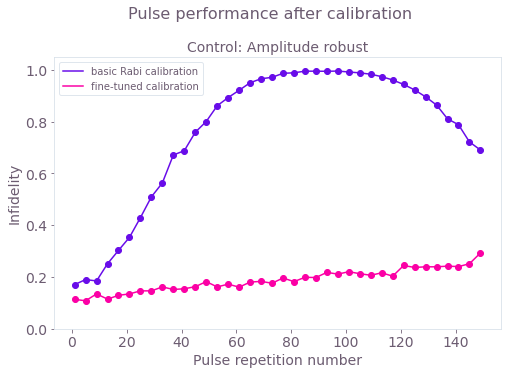

In [15]:
repetitions = np.arange(1, 151, 4)
num_shots_per_point = 2048
scheme_names = [key for key in gate_schemes.keys()]
scheme_names.insert(0, "Amplitude robust: basic calibration")

if use_saved_data == False:
    # Full pulse calibration
    calibrated_waveform = {}
    for scheme_name, control in gate_schemes.items():
        calibrated_waveform[scheme_name] = (
            best_scaling_I[scheme_name] * np.real(waveform[scheme_name])
            + 1j * np.imag(waveform[scheme_name])
        ) * best_scaling_amplitude[scheme_name]
        calibrated_waveform["%s: basic calibration" % scheme_name] = waveform[
            scheme_name
        ]

    pulse_program = {}
    for scheme_name in scheme_names:
        schedules = []
        for meas_basis in bloch_basis:
            for repetition in repetitions:
                control_pulse = Play(
                    Waveform(calibrated_waveform[scheme_name]), drive_chan
                )
                schedule = pulse.Schedule(
                    name=f"pulse_reps_" + str(repetition) + "_basis_" + str(meas_basis)
                )
                for reps in np.arange(repetition):
                    schedule += control_pulse
                if meas_basis == "x":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "y":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "z":
                    schedule |= measure_schedule << schedule.duration
                schedules.append(schedule)
        pulse_program[scheme_name] = assemble(
            schedules,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * (repetitions.shape[0])
            * 3,
        )

    # Running the jobs
    exp_results = {}
    for scheme_name in scheme_names:
        print("Control Scheme:", scheme_name)
        job = backend.run(pulse_program[scheme_name])
        print("Job id:", job.job_id())
        job_monitor(job)
        exp_results[scheme_name] = job.result(timeout=120)

    # Extract results
    calibrated_pulse_performance = {}
    for scheme_name, results in exp_results.items():
        print(scheme_name)
        idx = 0
        result_bloch = []
        for meas_basis in bloch_basis:
            full_res = []
            for idx_rep, number_of_repetitions in enumerate(repetitions):
                rep_res = []
                counts = results.get_counts()[idx]
                excited_pop = 0
                for bits, count in counts.items():
                    excited_pop += count if bits[::-1][qubit] == "1" else 0
                rep_res.append(excited_pop / num_shots_per_point)
                full_res.append(rep_res)
                idx += 1
            result_bloch.append(1 - 2 * np.asarray(full_res))
        calibrated_pulse_performance[scheme_name] = np.asarray(result_bloch)

    save_var(
        "resources/superconducting-qubits-pulse-calibration/calibrated_pulse_performance_Valencia_qubit_0",
        calibrated_pulse_performance,
    )
else:
    calibrated_pulse_performance = load_var(
        "resources/superconducting-qubits-pulse-calibration/calibrated_pulse_performance_Valencia_qubit_0"
    )

# Infidelities for repetition experiments
bloch_infidelity = {}
for scheme_name in scheme_names:
    bloch_vectors = np.array(
        [
            calibrated_pulse_performance[scheme_name][:, rep, 0]
            for rep in range(repetitions.shape[0])
        ]
    )
    bloch_infidelity[scheme_name] = (
        1 - ((1 + np.dot(bloch_vectors, target_bloch)) / 2) ** 2
    )

# Plotting
gs = gridspec.GridSpec(1, 1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)
fig.suptitle(f"Pulse performance after calibration", fontsize=16, y=1.02)
labels = {
    "Amplitude robust": "fine-tuned calibration",
    "Amplitude robust: basic calibration": "basic Rabi calibration",
}
ax = fig.add_subplot(gs[0])
for scheme_name in scheme_names:
    ax.set_title("Control: " + str(scheme_name), fontsize=14)
    ax.scatter(repetitions, bloch_infidelity[scheme_name])
    ax.plot(repetitions, bloch_infidelity[scheme_name], label=labels[scheme_name])
    ax.set_xlabel("Pulse repetition number", fontsize=14)
    ax.set_ylabel("Infidelity", fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_ylim(0, 1.05)
ax.legend(loc="best")
plt.show()

Gate performance under a pulse repetition experiment. The fine-tuning calibration of the pulse corrects the accumulation of errors that quickly appears up when using just the basic Rabi calibration.  